In [82]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Считывание данных

In [83]:
convert = lambda x: x if 0 < x > 150 else 0
convert = np.vectorize(convert)

In [84]:
warnings.filterwarnings("ignore")

In [85]:
if not os.path.isdir("raw_data"):
    os.chdir("../")

In [86]:
data = pd.read_excel("raw_data/Статистика_для_графиков_3_д_ТЭЦ2_УРУТ_130.xlsx")

In [87]:
data.columns

Index([                                                  'Дата',
                           'Выработка электроэнергии ТА гр.130',
                                 'Отпуск тепла из ТО ТА гр.130',
       'Удельный расход условного топлива на отпуск э/э гр.130',
                                                   'Unnamed: 4',
                                       'Предсказание полином 2',
                                           0.033374592702317095],
      dtype='object')

# Предобработка данных

In [88]:
target = "Удельный расход условного топлива на отпуск э/э гр.130"

In [89]:
columns_for_predictions = [
    column
    for column in data.columns[:-1]
    if "130" in column and column != "Удельный расход тепла на выработку э/э ТА гр.130"
]

In [90]:
columns_for_predictions

['Выработка электроэнергии ТА гр.130',
 'Отпуск тепла из ТО ТА гр.130',
 'Удельный расход условного топлива на отпуск э/э гр.130']

# Добавление фич даты

In [91]:
date = np.array([[0, 0, 0]], dtype=int)
for i in data["Дата"]:
    date = np.vstack([date, str(i.date()).split("-")])

In [92]:
date = date[1:]

In [93]:
data["year"] = date[:, 0]
data.year = data.year.apply(int)

In [94]:
data["month"] = date[:, 1]
data.month = data.month.apply(int)

In [95]:
data["day"] = date[:, 2]
data.day = data.day.apply(int)

In [96]:
data = data.drop(["Дата"], axis=1)

In [97]:
data.isna().sum()

Выработка электроэнергии ТА гр.130                           0
Отпуск тепла из ТО ТА гр.130                                 0
Удельный расход условного топлива на отпуск э/э гр.130       0
Unnamed: 4                                                1090
Предсказание полином 2                                       0
0.033374592702317095                                         0
year                                                         0
month                                                        0
day                                                          0
dtype: int64

In [98]:
data = data[columns_for_predictions + ["day", "month", "year"]]

# Обработка выбросов

In [99]:
data = data.loc[data[target] < 507]  # данные из predictions/xgb_fuel...
data = data.loc[data[target] > 100]

# Создание датасета для обучения
## Разделение данных

In [100]:
X = data.drop(target, axis=1)

In [101]:
y = data[target]

In [102]:
out_shape = 1

# Разделение на тренировочную и тестовую выборки

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=30)

# Catboost

In [121]:
model = CatBoostRegressor(iterations=3000)

In [122]:
X = np.array(X)
y = np.array(y)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [123]:
model.fit(X_train, y_train, verbose=500);

Learning rate set to 0.016688
0:	learn: 52.2174938	total: 1.83ms	remaining: 5.49s
500:	learn: 11.3610988	total: 330ms	remaining: 1.65s
1000:	learn: 8.8356554	total: 576ms	remaining: 1.15s
1500:	learn: 7.4715045	total: 805ms	remaining: 803ms
2000:	learn: 6.4620089	total: 1.04s	remaining: 520ms
2500:	learn: 5.6848610	total: 1.33s	remaining: 266ms
2999:	learn: 5.0271828	total: 1.63s	remaining: 0us


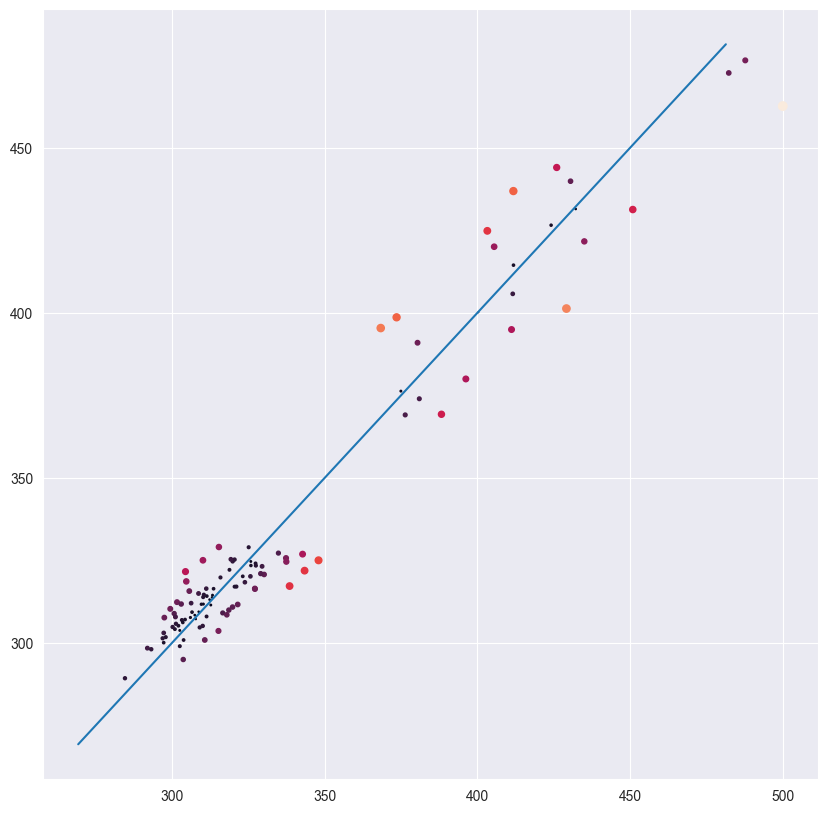

In [124]:
test_predictions = np.array(model.predict(X_test))
area = abs(y_test - test_predictions)
plt.figure(figsize=(10, 10))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(y_test, test_predictions, marker='o', s=area, c=area);

In [125]:
predictions = np.array(model.predict(X_test))

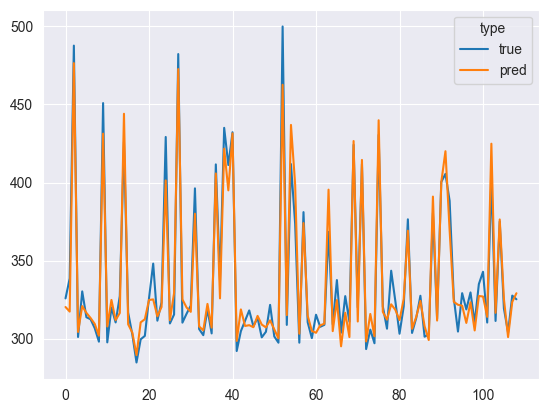

In [126]:
plt.plot(y_test, label="true")
plt.plot(predictions, label="pred")
plt.legend(title="type")
plt.savefig("cat_boost_predictions.png");

In [127]:
r2_score(y_test, predictions)

0.9485089583399312

In [128]:
for i in zip(y_test, predictions):
    if abs(i[0] - i[1]) > 20:
        print(i[0], i[1])

338.566673 317.2851133715334
348.03684 325.0838600453952
429.177924 401.3289833784111
499.985903 462.6461438410485
411.812614 436.9112934313491
373.586281 398.67788141602995
368.395934 395.42346449963713
343.471583 321.9526110397449
403.281922 424.8644088849151


In [129]:
abs(y_test - predictions).max()

37.339759158951495

In [130]:
model = CatBoostRegressor(iterations=7001)

In [131]:
model.fit(X, y, verbose=500);

Learning rate set to 0.008521
0:	learn: 52.0347694	total: 1.76ms	remaining: 12.3s
500:	learn: 13.7599373	total: 274ms	remaining: 3.56s
1000:	learn: 11.3139086	total: 545ms	remaining: 3.27s
1500:	learn: 9.8644060	total: 812ms	remaining: 2.97s
2000:	learn: 8.8222048	total: 1.09s	remaining: 2.72s
2500:	learn: 8.0320692	total: 1.36s	remaining: 2.44s
3000:	learn: 7.3682042	total: 1.63s	remaining: 2.17s
3500:	learn: 6.8410283	total: 1.9s	remaining: 1.9s
4000:	learn: 6.3939291	total: 2.16s	remaining: 1.62s
4500:	learn: 5.9969834	total: 2.43s	remaining: 1.35s
5000:	learn: 5.6561949	total: 2.7s	remaining: 1.08s
5500:	learn: 5.3477999	total: 2.96s	remaining: 806ms
6000:	learn: 5.0607964	total: 3.23s	remaining: 539ms
6500:	learn: 4.7978905	total: 3.51s	remaining: 270ms
7000:	learn: 4.5604518	total: 3.78s	remaining: 0us


In [132]:
predictions = np.array(model.predict(X))

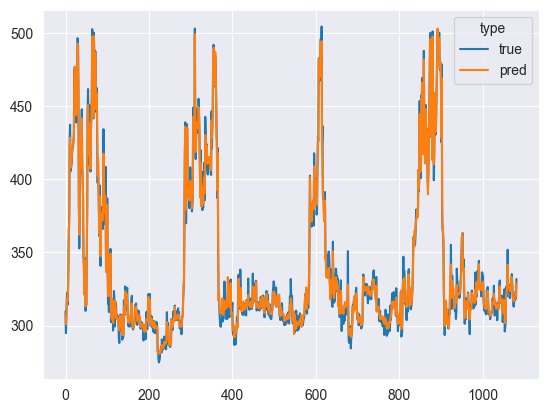

In [133]:
plt.plot(y, label="true")
plt.plot(predictions, label="pred")
plt.legend(title="type")
plt.savefig("predictions.png");

In [134]:
r2_score(y, predictions)

0.9924213671575078

In [135]:
for i in zip(y, predictions):
    if abs(i[0] - i[1]) > 20:
        print(i[0], i[1])

408.524472 382.6192177637753
436.492642 415.36052276456013
350.87063 328.0432146165735


In [136]:
abs(y - predictions).max()

25.90525423622472

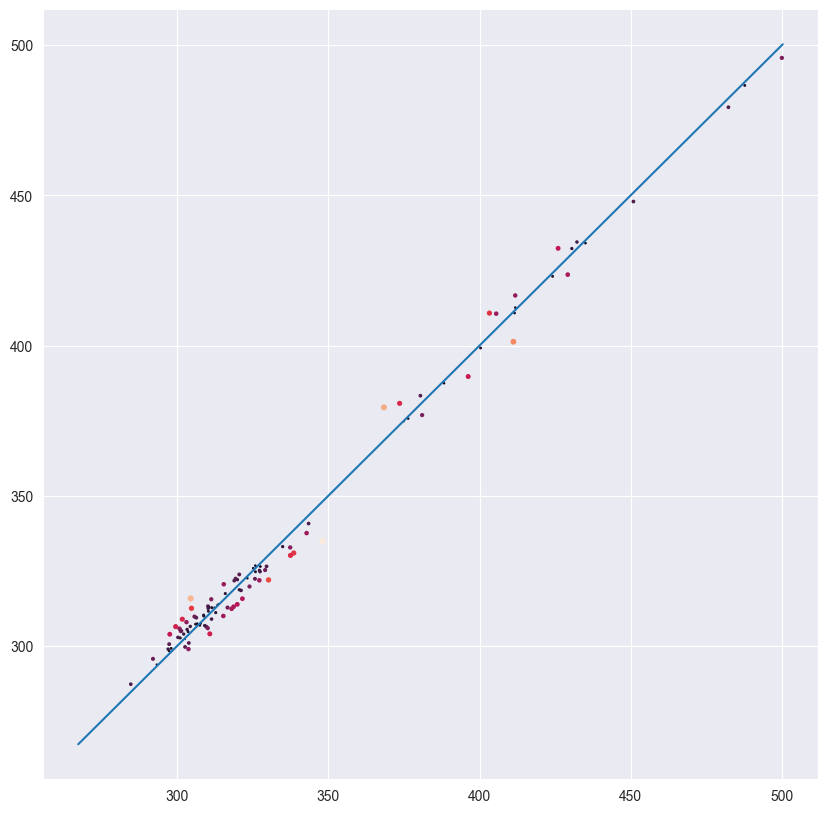

In [137]:
test_predictions = np.array(model.predict(X_test))
area = abs(y_test - test_predictions)
plt.figure(figsize=(10, 10))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(y_test, test_predictions, marker='o', s=area, c=area);